# Evaluating speech polarization over time

In [1]:
import os
import sys
PATH = "/home/piotr/projects/twitter"
PATH_DATA = os.path.join(PATH, "data/clean")
NUM_WORKERS = 3
sys.path.append('../src')
import pandas as pd
import pandarallel
pandarallel.pandarallel.initialize(nb_workers = NUM_WORKERS)
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import gc
import json
import pickle
import random
from tqdm.notebook import tqdm, trange
from functools import partial
import ast
import pdb
import logging


from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, read_window
from twitter_tools.evaluation import polarization as evaluation


from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import nltk

import ipywidgets as widgets
from ipywidgets import interact

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')
START = '2020_02_23'
END = '2020_07_15'
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
PATH_TOKENS = os.path.join(PATH, 'results/topics/mallet/topic_tokens.json')
topic_tokens = json.load(open(PATH_TOKENS, 'r'))

In [3]:
gov = pickle.load(open(os.path.join(PATH, 'data/sample/gov_sample.p'),"rb"))
opp = pickle.load(open(os.path.join(PATH, 'data/sample/opp_sample.p'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})



#Get random assignment
random.seed(1234)
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [4]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list, drop_duplicates = True, keep_cols = None, **kwargs):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True, **kwargs)
    if keep_cols is not None:
        df = df[keep_cols]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, 
             subset = ['lemmatized'], keep_cols = ['full_text', 'day','lemmatized','id_str','user-id_str', 'source', 'lemmas'])

def weighted_average(group, weight_name):
    weights = group['n']
    score = group['score']   
    return np.average(score,weights=weights)

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

# 1. Partisanship over time - day level

### 1.1 Overall partisanship
- using all data
- excluding duplicated Tweets

#### Day-level estimates: 

In [5]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = dict() #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'true')] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'random')] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.to_csv(PATH_RESULTS)

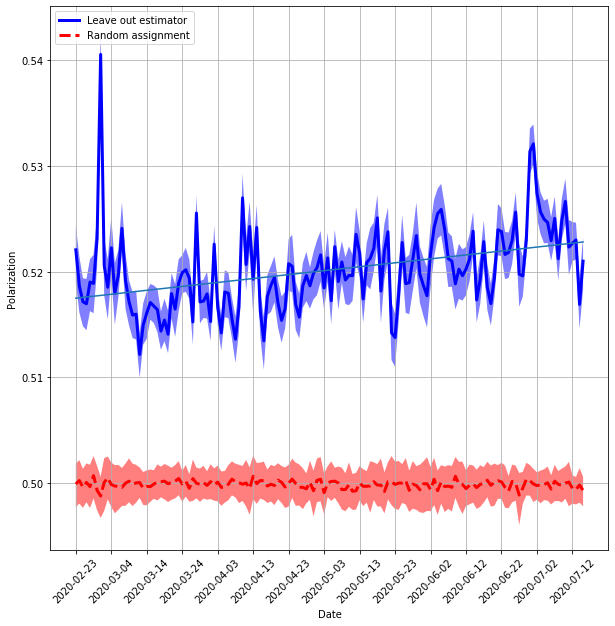

In [68]:
evaluation.plot_aggregated(results, trend_line = True)

#### Day-level smoothed estimates
To obtained "smoother" version of the daily the estimates, I use rolling-window of 7 days to compute the vocabulary on which the estimates are based. For example, the "smoothed" estimate for 5th of March uses the vocabulary between the 2th and 8th of March to fit the ngram tokenizer, and then only phrases used on the 5th to compute the polarization on that particular day.

In [15]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    results = dict()
    for df in tqdm(read_window(PATH_DATA, n=7, batch_size=1,
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        # fit vectorizer on all vocabulary:
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1, 2),
                                  log=20, n_jobs=4, stop_words=stopwords)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        results[(mid_date, 'true')] = model.estimate(df['source'],
                                                     df['user-id_str'],
                                                     df['lemmatized'],
                                                     level='aggregate',
                                                     conf_int=100,
                                                     leave_out=True)
        random_parties = df["user-id_str"].astype(str).apply(lambda x: randomized.get(x))
        results[(mid_date, 'random')] = model.estimate(random_parties,
                                                       df['user-id_str'],
                                                       df['lemmatized'],
                                                       level='aggregate',
                                                       conf_int=100,
                                                       leave_out=True)

    results = pd.DataFrame.from_dict(results, orient='index')
    results.index.names = ['date', 'type']
    results.to_csv(PATH_RESULTS)

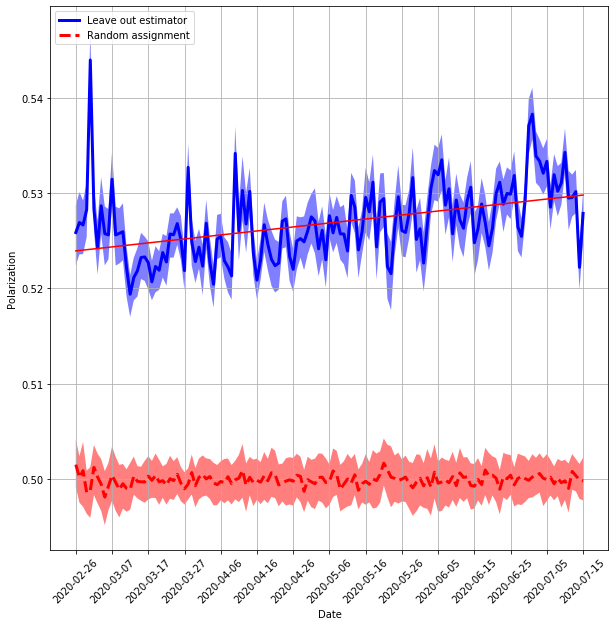

In [8]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 10)
plt.show()

#### Robustness to Tweet length:

In [6]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_window_test.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    results = dict()
    for df in tqdm(read_window(PATH_DATA, n=7, batch_size=1,
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        df['ntokens'] = df['lemmas'].apply(lambda x: len(ast.literal_eval(x)))
        df = df.loc[df['ntokens'] >= df['ntokens'].median(), :]
        # fit vectorizer on all vocabulary:
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1, 2),
                                  log=20, n_jobs=4, stop_words=stopwords)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        results[(mid_date, 'true')] = model.estimate(df['source'],
                                                     df['user-id_str'],
                                                     df['lemmatized'],
                                                     level='aggregate',
                                                     conf_int=100,
                                                     leave_out=True)
        random_parties = df["user-id_str"].astype(str).apply(lambda x: randomized.get(x))
        results[(mid_date, 'random')] = model.estimate(random_parties,
                                                       df['user-id_str'],
                                                       df['lemmatized'],
                                                       level='aggregate',
                                                       conf_int=100,
                                                       leave_out=True)

    results = pd.DataFrame.from_dict(results, orient='index')
    results.index.names = ['date', 'type']
    results.to_csv(PATH_RESULTS)

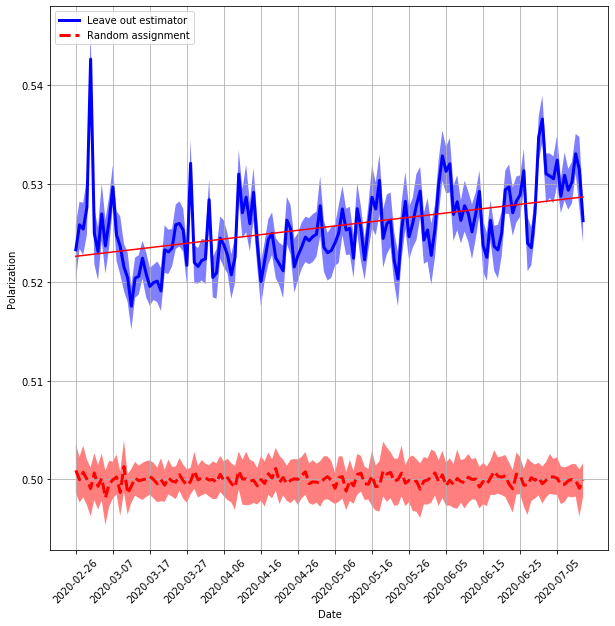

In [9]:
#results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 10)
plt.show()

#### Robustness to vocabulary window size

In [6]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = dict() #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype=dtypes, filter_fun=ff, batch_size=7)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = sorted(pd.to_datetime(data['day'].unique()))[3]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'true')] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int=100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'random')] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int=100)
    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.to_csv(PATH_RESULTS)

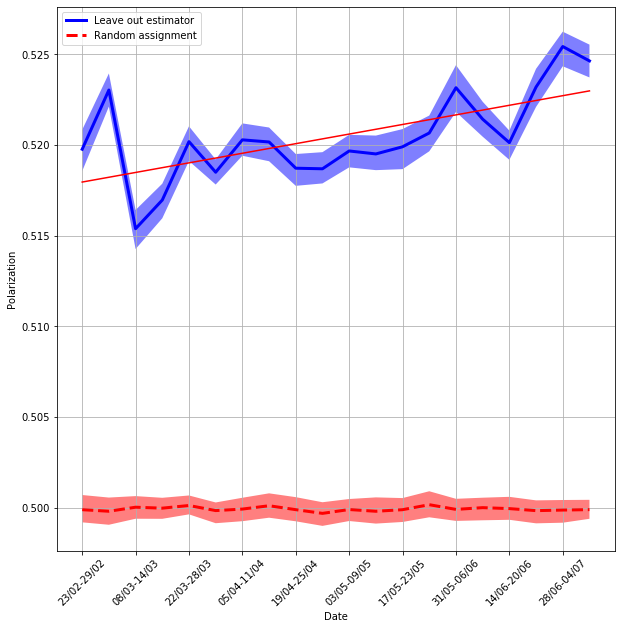

In [11]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 2)
plt.show()

### 1.2 Within-topics partisanship, based on the LDA-Mallet topic model

#### Day-level estimates of topic partisanship

In [5]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    part_within = dict() #store estimates
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = 20)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        #get estimates by topic:
        part_within_t = data.groupby('topic').parallel_apply(lambda gr: model.estimate(gr['source'], 
                                                                                       gr['user-id_str'], 
                                                                                       gr['lemmatized'], 
                                                                                       level = 'aggregate',
                                                                                       conf_int = None))
        part_within_t = part_within_t.to_dict() #convert to dict
        part_within_t = {(k, mid_date):v for k, v in part_within.items()}
        part_within.update(part_within_t) #update all
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')

    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within[['gov','opp']] = pd.json_normalize(part_within['n'])
    del part_within['n']
    part_within.set_index(['topic','date'], inplace = True)
    part_within['n'] = part_within['gov'] + part_within['opp']
    part_within.to_csv(PATH_RESULTS)

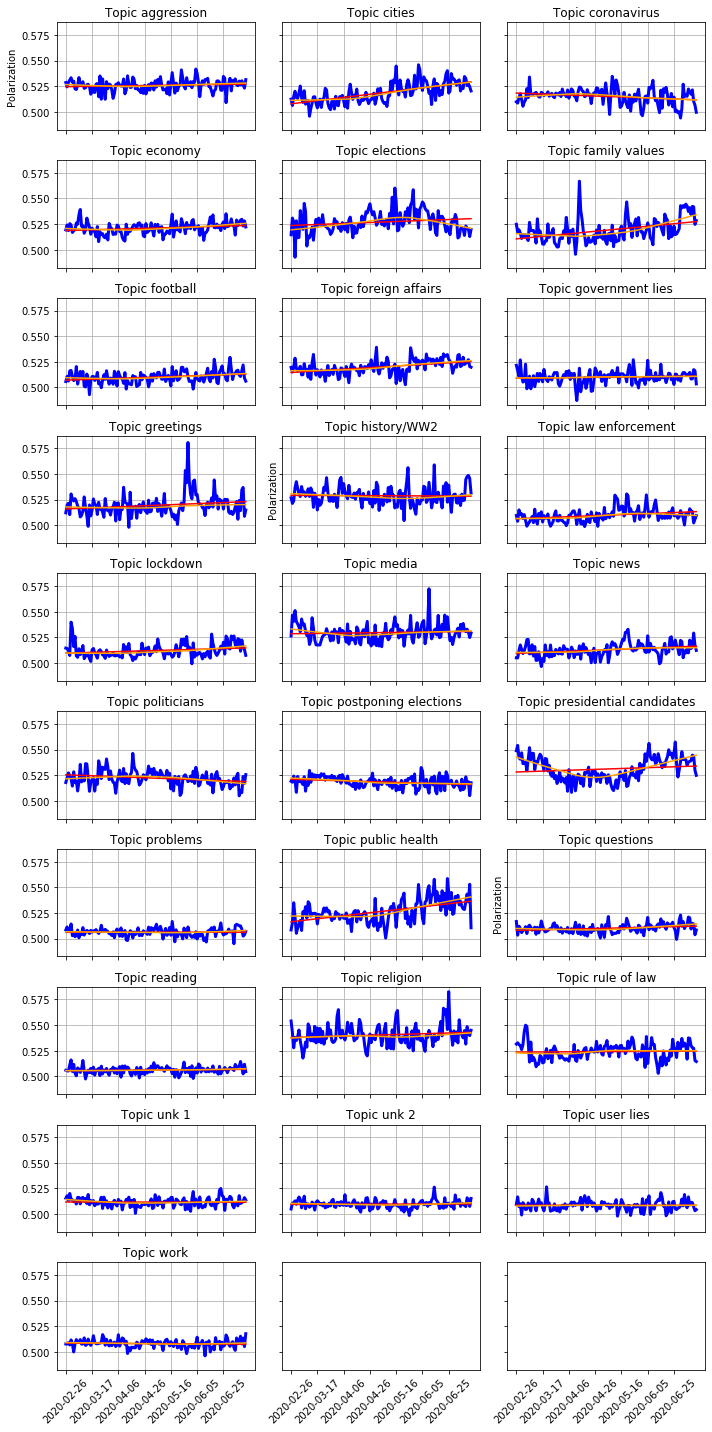

In [7]:
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
part_within = part_within[part_within['topic'] != 0]
part_within['topic_label'] = part_within['topic'].astype(str).map(topic_dict)
evaluation.plot_aggregated_bytopic(part_within.date, part_within.point, 
                                   part_within.topic_label, figsize = (10, 20), 
                                   trend_line = True, lowess = True, dims = (10, 3))

#### Polarization autocorrelation within each topic:
To examine the presence of the trend, I have also plotted the autocorrelation of each topic-polarization time series for 20 lags.

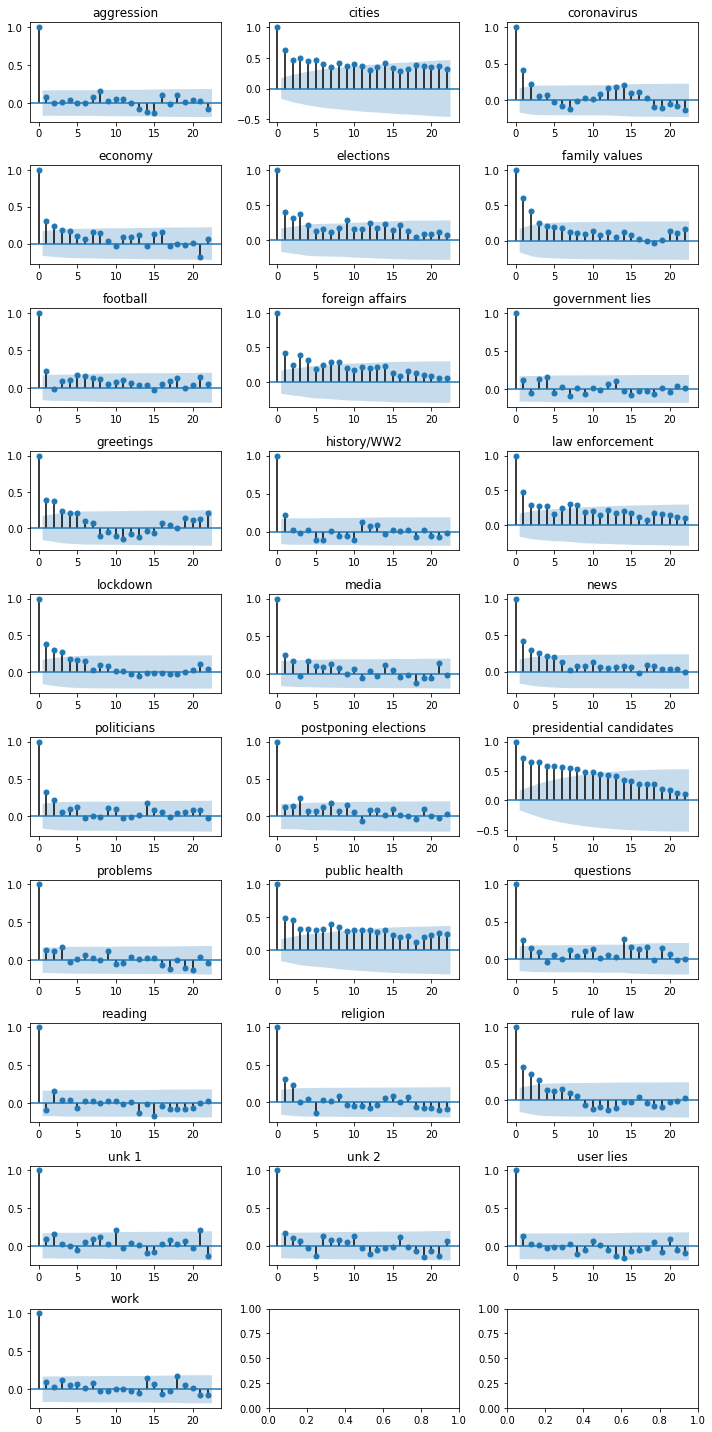

In [40]:
fig, ax = plt.subplots(10, 3, figsize = (10, 20))
ax = ax.ravel()
for i, (topic, df) in enumerate(part_within.groupby('topic_label')):
    plot_acf(df['point'], ax = ax[i])
    ax[i].set_title(f'{topic}')
plt.tight_layout()
plt.show()

#### Linear fits:
To further investigates trends within each of the topics, I fitted an OLS regression for each of them, and examined the slope and the intercept.

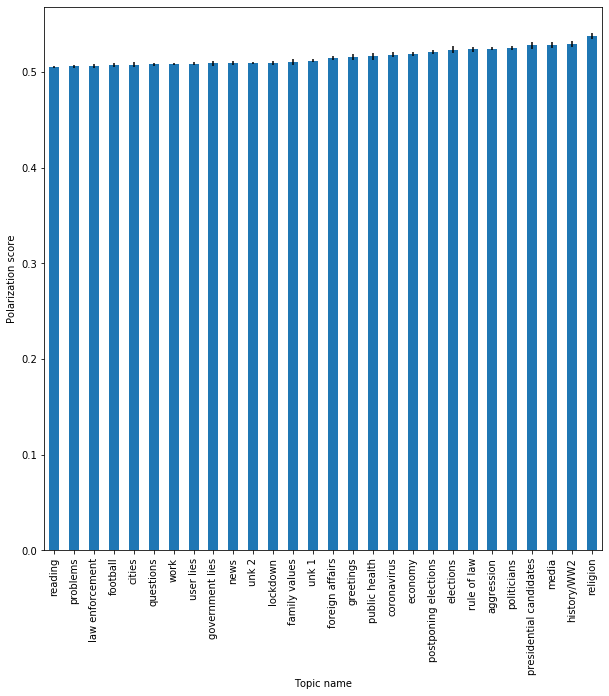

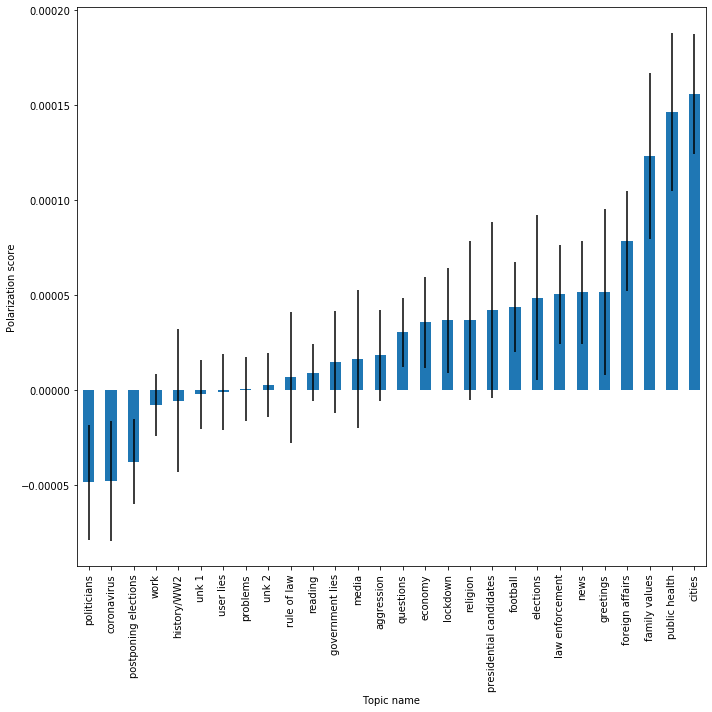

In [43]:
fits = pd.DataFrame(columns = ['lower','upper', 'point','topic'])
date_num = np.arange(len(np.unique(part_within.reset_index().date)))
X = sm.add_constant(date_num)
for topic, df in part_within.groupby('topic_label'):
    model = sm.OLS(df['point'], X)
    fit = model.fit()
    res = fit.conf_int()
    res.columns = ['lower','upper']
    res['point'] = fit.params
    res['topic'] = topic
    fits = fits.append(res)
fits.set_index('topic', inplace = True, append = True)
fits.index.names = ['coef','topic']
fits = fits.reset_index()
fits['err'] = fits['upper'] - fits['point']
axes = fits.reset_index().sort_values('point').groupby(['coef']).plot.bar('topic','point',figsize = (10, 10), yerr = 'err')
for ax in axes:
    ax.get_legend().remove()
    #ax.set_xticklabels(fits['topic'].unique(), rotation = 45)
    ax.set_ylabel('Polarization score')
    ax.set_xlabel('Topic name')
plt.tight_layout()
plt.show()

#### Week-level estimates of topic partisanship with confidence intervals

In [8]:
def fit_pol(df, **kwargs):
        model = ModelPolarization(parties=["gov", "opp"], limit=40, n_jobs=1, ngram_range=(1,2))
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        est = model.estimate(df['source'], df['user-id_str'], df['lemmatized'], 
                       text_id = df['id_str'],**kwargs)
        del model
        gc.collect()
        return est

In [5]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly_topics.csv")
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    part_within = dict() #store estimates
    for df in tqdm(read_files(PATH_DATA, batch_size=7, day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):

        dates = sorted(pd.to_datetime(df['day'].unique()))
        date_start = dates[0].date().strftime('%m/%d')
        date_end = dates[-1].date().strftime('%m/%d')
        date_range = date_start + ' - ' + date_end
        #get estimates by topic:
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        part_within_t = df.groupby('topic').parallel_apply(lambda gr: fit_pol(gr, conf_int=100, level='aggregate'))
        part_within_t = part_within_t.to_dict() #convert to dict
        part_within_t = {(k, date_range):v for k, v in part_within_t.items()}
        part_within.update(part_within_t) #update all
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')
    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within.to_csv(PATH_RESULTS)

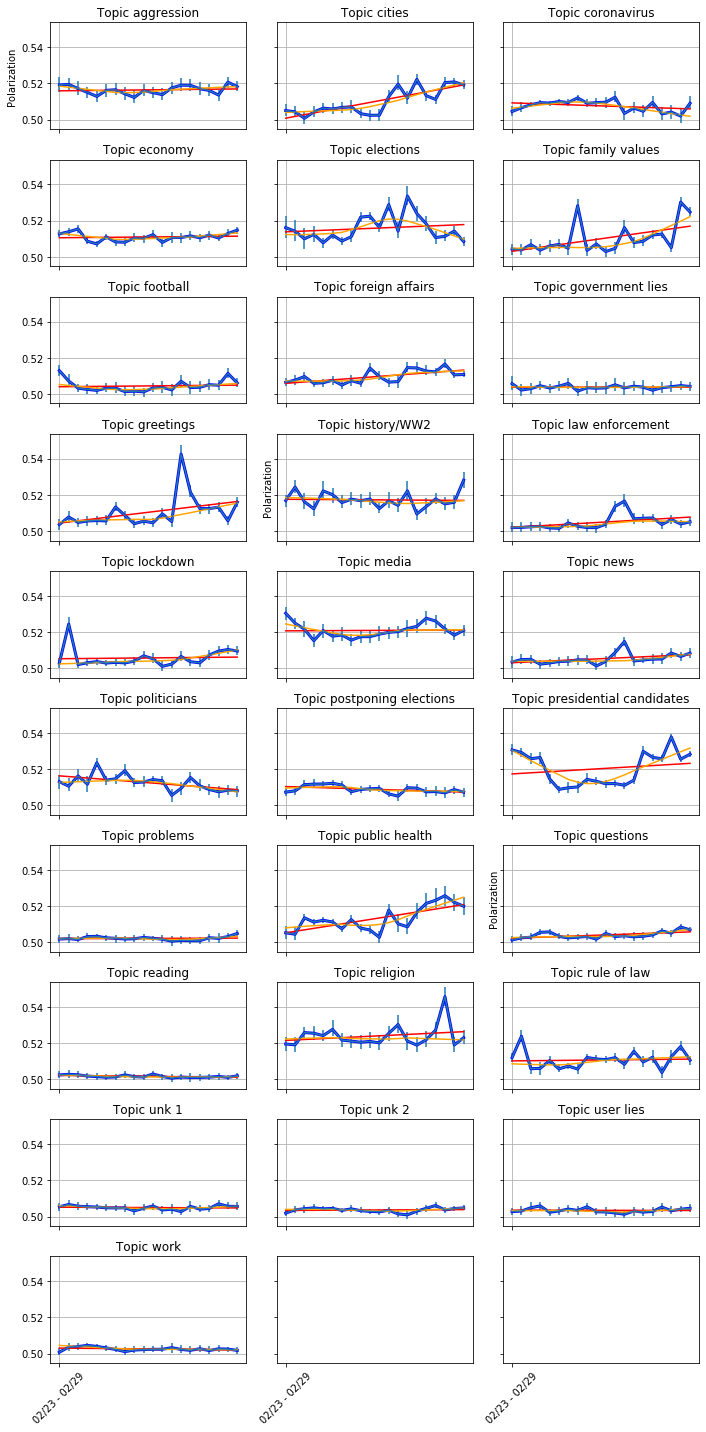

In [23]:
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
part_within[['upper_ci_diff', 'lower_ci_diff']] = np.abs(part_within[['upper_ci','lower_ci']] - part_within['estimate'].to_numpy()[:,np.newaxis])
topic_dict = json.load(open(PATH_DICT, 'r'))
part_within = part_within[part_within['topic'] != 0]
part_within['topic_label'] = part_within['topic'].astype(str).map(topic_dict)
evaluation.plot_aggregated_bytopic(part_within.date, part_within.estimate,
                                   part_within.topic_label, error=part_within[['upper_ci_diff', 'lower_ci_diff']].to_numpy().T, 
                                   figsize=(10, 20), trend_line=True, lowess=True, dims=(10, 3))

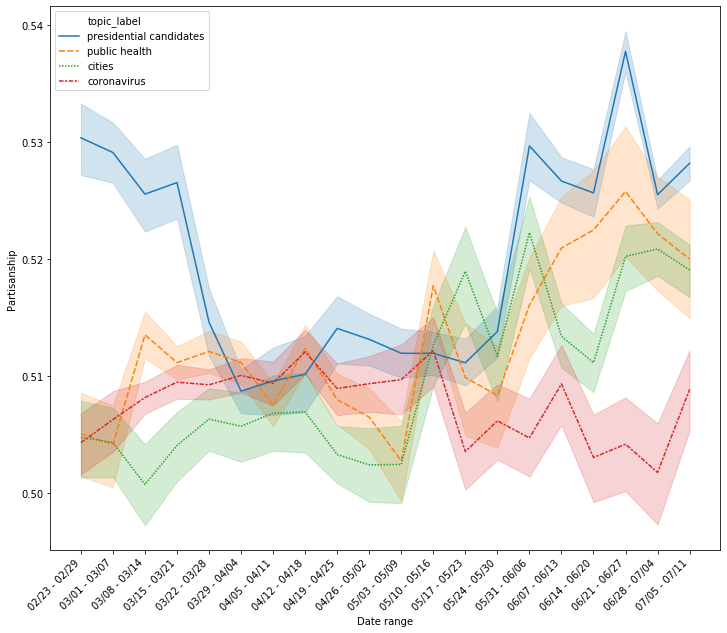

In [35]:
subdf = part_within[part_within['topic_label'].isin(['presidential candidates', 'public health', 'coronavirus', 'cities'])]
subdf = subdf.melt(id_vars=['topic','date','topic_label'], value_vars=['lower_ci','upper_ci','estimate'], value_name='est')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.lineplot('date', 'est', hue='topic_label', style='topic_label', data=subdf, ci=100, ax=ax)
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel('Partisanship')
plt.xlabel('Date range')
plt.show()

### 1.3.  Between-topic partisanship:
I then proceed to compute the daily polarization between topics. The **between-topic** polarization estimate, is defined as the expected posterior probability of assigning a speech to the correct party, assuming the observer knows only the topic, i.e. disregarding the content of the tweets. This allows to evaluate the level of polarization determined only by the topics chosen by the partisans, not by the phrases they use to discuss them.

In [44]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_between = pd.read_csv(PATH_RESULTS, index_col = 0)['score']
else:
    part_between = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        topics = data['id_str'].astype(str).map(topic_map)
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        part_between[day] = model.estimate_topics(parties, topics)
    part_between = pd.DataFrame.from_dict(part_between, orient = 'index')
    part_between.columns = ['score']
    part_between = part_between['score']
    part_between.to_csv(PATH_RESULTS)

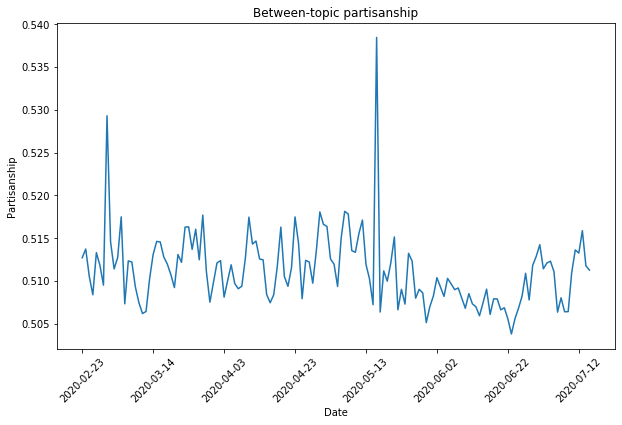

In [46]:
part_between.plot(rot = 45, figsize = (10, 6), legend = False, title = 'Between-topic partisanship')
plt.xlabel('Date')
plt.ylabel('Partisanship')
plt.show()

### 1.4. Comparison of partisanship:

Following Gentzkow et al., to decompose the sources of polarization I calculate **within-topic** polarization as an average of the polarization within each of the identified topic, weighted by the total number of users tweeting on the topic on a given day. I then compare it with the **between-topic** polarization obtained in the previous section. This decomposition provides a way of determining to what extent is the change in polarization over time driven by the difference in which partisans tweet on the same topic vs. the difference in topics on which they tweet.

In [47]:
part_within = part_within.reset_index().set_index('topic')
tmp = part_within.groupby(['date']).apply(lambda x: x['n']/x['n'].sum())
tmp = tmp.reset_index().melt(id_vars = 'date')
tmp.columns = ['date','topic','prop']
tmp = tmp.set_index(['topic','date'])
part_within = part_within.set_index('date',append = True)
part_within = part_within.join(tmp, how = 'left')
part_within['point_wtd'] = part_within['point'] * part_within['prop']
plot_data = part_within['point_wtd'].reset_index().pivot(index = 'date', columns = 'topic')
plot_data.columns = plot_data.columns.droplevel(0)

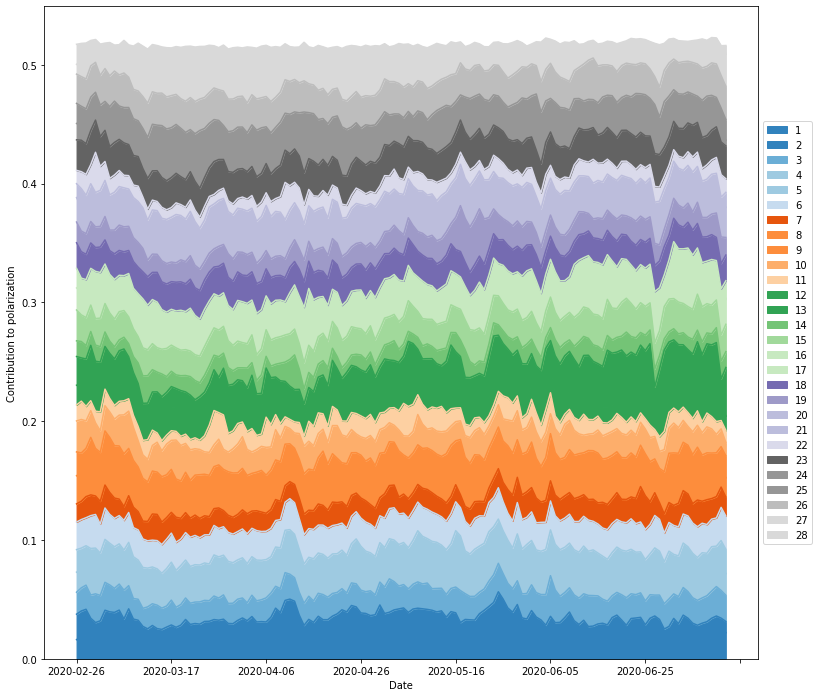

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
plot_data.plot.area(ax = ax, cmap = 'tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Contribution to polarization')
ax.set_xlabel('Date')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [49]:
PATH_BETWEEN = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
PATH_WITHIN = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
PATH_OVERALL = os.path.join(PATH, "results/polarization/polarization_daily.csv")

#BETWEEN PARTISANSHIP
part_between = pd.read_csv(PATH_BETWEEN, index_col = 0)['score']

#WITHIN PARTISANSHIP:
part_within = pd.read_csv(PATH_WITHIN, index_col = 0)
part_within = part_within.reset_index().groupby('date').apply(lambda x: np.average(x['point'], weights = x['n']))

#OVERALL PARTISANSHIP:
part_overall = pd.read_csv(PATH_OVERALL, index_col = 0)
part_overall = part_overall[part_overall['type'] == 'true'].set_index('date')['estimate']

#COMBINE:
part = pd.DataFrame(dict(within = part_within, between = part_between, overall = part_overall))

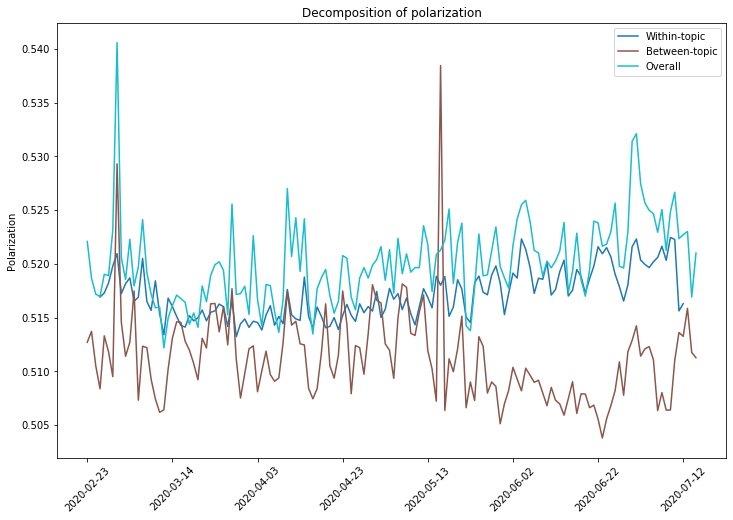

In [50]:
part.plot(figsize = (12, 8), rot = 45, title = 'Decomposition of polarization',  cmap = 'tab10')
plt.ylabel('Polarization')
plt.legend(['Within-topic', 'Between-topic', 'Overall'])
plt.show()

The level of partisanship seems to have increased in the topics of presidential candidates, finance, media and decreased in political parties, coronavirus, and elections. 

# 3. Phrase partisanship
To evaluate the partisanship of particular phrases, I obtained the posterior probability pf a phrase being assigned to the government by an observer with neutral prior based on the Gentzkow model. I then looked at phrases which occured on at least 115 days (i.e. less than 40 days missingness), and examined phrases with highest government partisanship (i.e. posterior close to 1), opposition partisanship (i.e. posterior close to 0) and highest variation in partisanship over time.

In [43]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship.csv')
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 'date')
else:
    phrases = dict()
    for df in tqdm(read_window(PATH_DATA, window_size=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = 20)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        parties = df["source"] #get parties 
        users = df["user-id_str"] #get users 
        tweets = df["lemmatized"].astype(str) #get tweets
        day = df['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        phrases[mid_date] = model.get_posteriors(parties, users, tweets)
    phrases = pd.DataFrame.from_dict(phrases).reset_index().melt('index')
    phrases.columns = ['phrase','date','posterior']
    phrases = phrases.set_index(['date'])
    phrases.to_csv(PATH_RES)

In [44]:
phrases = phrases[np.logical_not(phrases.phrase.isin(stopwords))]
summary = phrases.groupby('phrase').agg({'posterior':[np.mean, np.std, lambda x: x.isna().sum()]})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['posterior_mean','posterior_sd','posterior_miss']

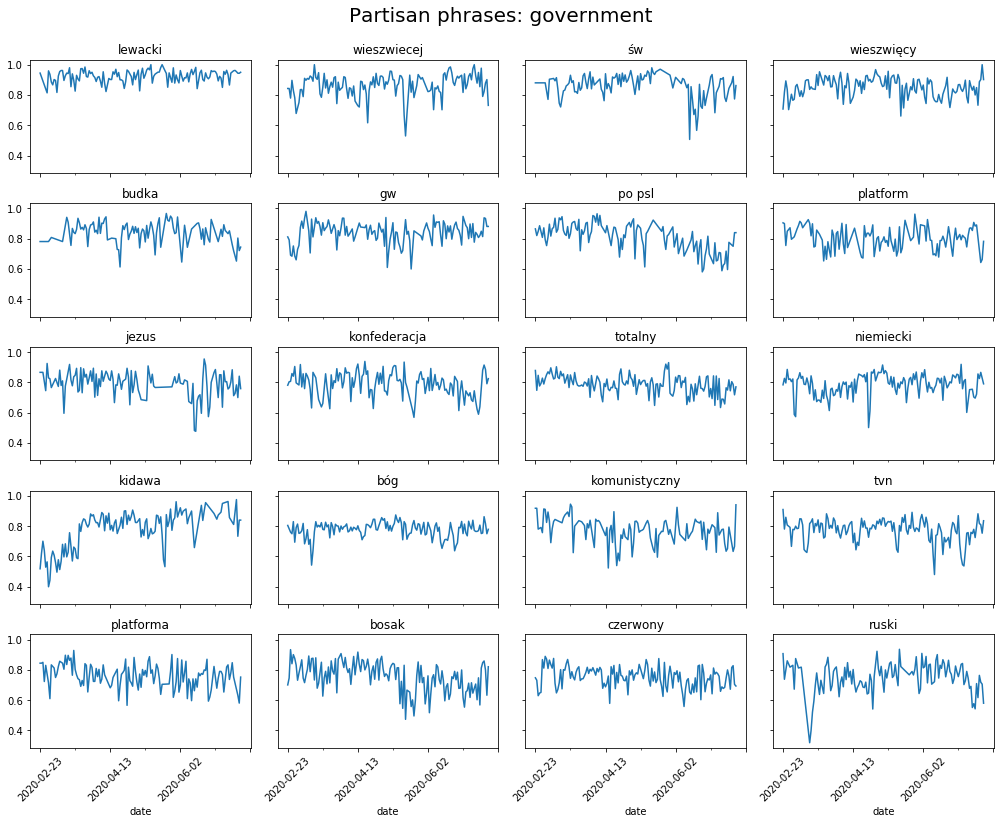

In [13]:
phrases_gov = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: government', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_gov.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

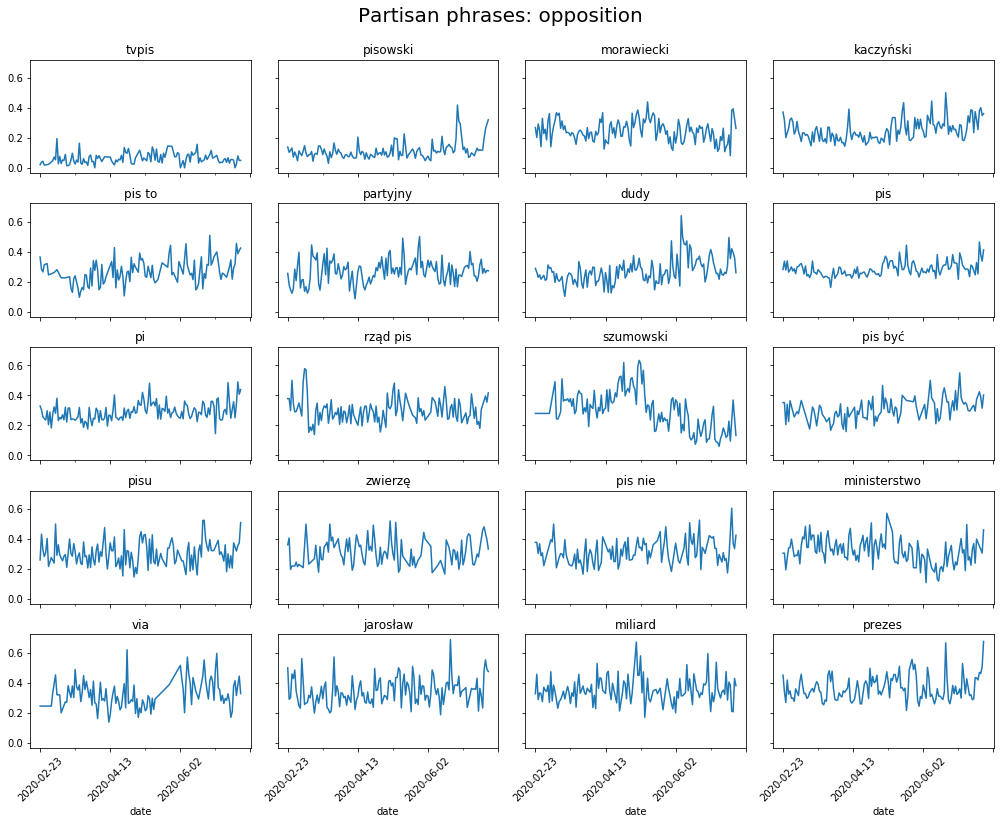

In [14]:
phrases_opp = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = True).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: opposition', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_opp.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

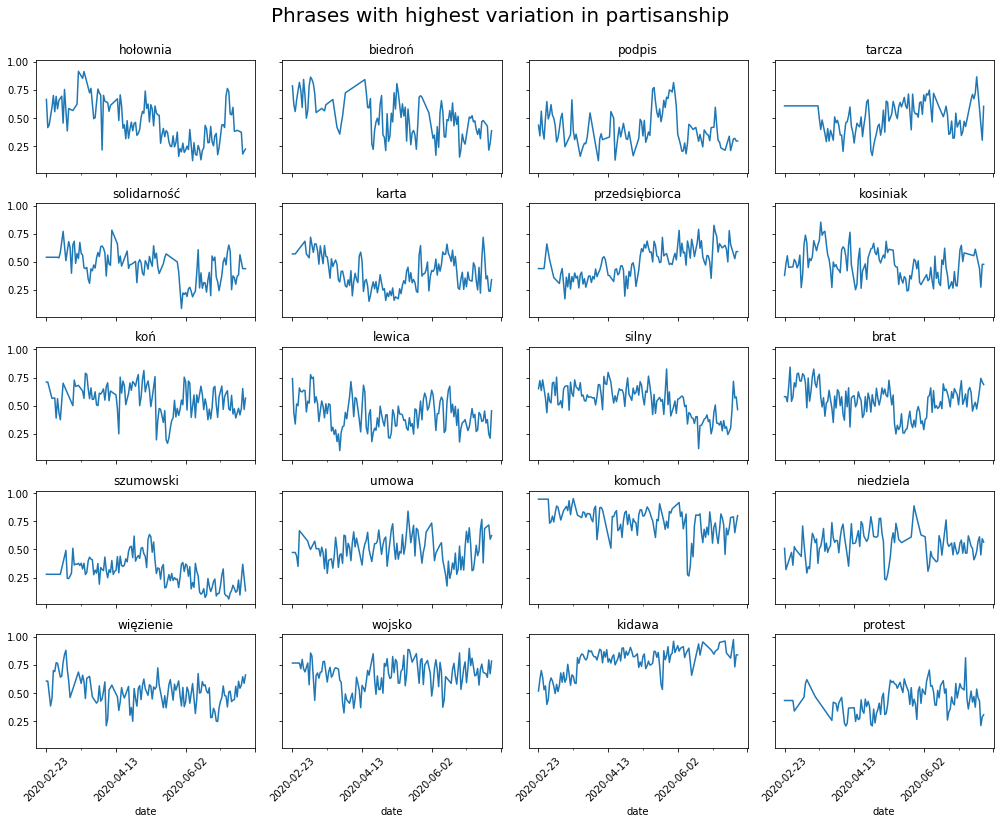

In [15]:
phrases_var = summary[summary.posterior_miss < 40].sort_values(['posterior_sd'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Phrases with highest variation in partisanship', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_var.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### By topic:

In [5]:
def polarization(sources, users, texts):
    model = ModelPolarization(parties = ["gov", "opp"], limit = 10, ngram_range = (1,2), log = 20, stop_words = stopwords)
    post = model.get_posteriors(sources, users, texts)
    #tokenize:
    tokens = nltk.word_tokenize("\n".join(texts.tolist()))
    tokens = [w for w in tokens if w in list(model.vectorizer.vocabulary_.keys())] #stopwords and under min_df

    #get bigram counts:
    bgs = nltk.bigrams(tokens)
    counts = nltk.FreqDist(bgs)
    counts = {" ".join(k):v for k, v in counts.items()}
    #and unigram counts:
    counts.update(nltk.FreqDist(tokens))
    res = dict()
    for w in post:
        res[w] = {'score':post[w], 'n':counts[w]}
    del model
    gc.collect()
    return res

In [6]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship_bytopic.csv')
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 0)
else:
    phrases = dict()
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        #get posteriors
        phrases_bytopic = df.groupby('topic').parallel_apply(lambda gr: polarization(gr['source'], gr['user-id_str'], gr['lemmatized']))
        phrases_bytopic = phrases_bytopic.to_dict()
        for topic, res in phrases_bytopic.items():
            for w in res:
                phrases[(mid_date, topic, w)] = res[w]
    phrases = pd.DataFrame.from_dict(phrases, orient = 'index')
    phrases.reset_index(inplace = True)
    phrases.columns = ['date','topic','phrase', 'score', 'n']
    phrases.set_index(['topic','phrase'], inplace = True)
    phrases['num_days'] = phrases.groupby(phrases.index).size()
    phrases = phrases.reset_index()
    phrases.to_csv(PATH_RES)

In [7]:
phrase_polarization = phrases[phrases.num_days >= 30].groupby(['topic','phrase']).apply(lambda x: weighted_average(x, 'n')).reset_index()
phrase_polarization.columns = ['topic','phrase','score']
phrase_polarization['topic_label'] = phrase_polarization['topic'].astype(str).map(topic_dict)
phrase_polarization['top_tokens'] = phrase_polarization['topic'].astype(str).apply(lambda x: " ".join(uniques.get(x)))

In [99]:
phrase_pol_opp = phrase_polarization.sort_values(['topic_label', 'score']).groupby('topic_label').head(15)
phrase_pol_gov = phrase_polarization.sort_values(['topic_label', 'score'], ascending = False).groupby('topic_label').head(15).sort_values('topic_label')
phrase_pol_gov.to_csv(os.path.join(PATH, 'results/polarization/gov_polarized.csv'))
phrase_pol_opp.to_csv(os.path.join(PATH, 'results/polarization/opp_polarized.csv'))

In [23]:
@interact
def show_articles_more_than(topic = list(sorted(phrase_polarization.topic_label.unique())), group = ['all', 'government', 'opposition'], topn = 5):
    if group == 'government':
        ind = phrase_polarization['score'].groupby(phrase_polarization['topic_label']).nlargest(n = topn).index.droplevel(0)
        df = phrase_polarization.iloc[ind]
    elif group == 'opposition':
        ind = phrase_polarization['score'].groupby(phrase_polarization['topic_label']).nsmallest(n = topn).index.droplevel(0)
        df = phrase_polarization.iloc[ind]
    elif group == 'all':
        df = phrase_polarization
    return df.loc[df['topic_label'] == topic]

interactive(children=(Dropdown(description='topic', options=('aggression', 'cities', 'coronavirus', 'economy',…